In [1]:
import sys


from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from tqdm import tqdm
from aquarel import Theme

sys.path.append("../../")
from set_encoder.data.datamodule import SetEncoderDataModule
from set_encoder.model.set_encoder import SetEncoderClassFactory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
theme = Theme.from_file(Path.home() / "aquarel-theme.json")
del theme.params["grid"]
theme.apply()
markers = ["o", "X", "s", "v", "P", "*", "D"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
BASELINE_RUN_DIR = Path("../../data/baseline-runs/colbert/")
LOGS_DIR = Path("../../experiments/set_encoder/wandb/")

In [4]:
mono_electra = "gl9bq8ip"
set_encoder = "e8bypanb"

In [5]:
def grab_attention(model_name):
    checkpoint_path = list(
        LOGS_DIR.glob(f"*{model_name}/files/huggingface_checkpoint")
    )[0]
    config = transformers.AutoConfig.from_pretrained(checkpoint_path)
    model_class = transformers.AutoModelForSequenceClassification._model_mapping[
        type(config)
    ]
    SetEncoder = SetEncoderClassFactory(model_class)
    set_encoder = SetEncoder.from_pretrained(checkpoint_path, use_flash=False)
    set_encoder = set_encoder.eval().to(device)

    datamodule = SetEncoderDataModule(
        str(checkpoint_path),
        "listwise",
        predict_ir_dataset_paths=[
            BASELINE_RUN_DIR / "msmarco-passage-trec-dl-2019-judged.run",
            BASELINE_RUN_DIR / "msmarco-passage-trec-dl-2020-judged.run",
        ],
        max_length=512,
        predict_batch_size=1,
        depth=100,
    )

    datamodule.setup("predict")
    dataloaders = datamodule.predict_dataloader()

    total = sum(len(dataloader) for dataloader in dataloaders)
    pg = tqdm(total=total)

    cls_attention = []
    query_attention = []
    doc_attentions = []
    other_doc_attentions = []

    token_idx = 0

    for dataloader in dataloaders:
        for batch in dataloader:
            with torch.no_grad():
                output = set_encoder(
                    input_ids=batch["input_ids"].to(device),
                    attention_mask=batch["attention_mask"].to(device),
                    token_type_ids=batch["token_type_ids"].to(device),
                    num_docs=batch["num_docs"],
                    output_attentions=True,
                )
                attention = np.stack(
                    list(attention.cpu().numpy() for attention in output.attentions)
                )
                query_len = (
                    (batch["token_type_ids"] == 0) & (batch["attention_mask"] == 1)
                ).sum(1)[0].item() - 1
                start_offset = 1
                doc_lens = (batch["token_type_ids"] == 1).sum(1)
                num_docs = batch["num_docs"][0]

                cls_attention.append(attention[..., token_idx, 0].mean(axis=(-1, -2)))

                query_attention.append(
                    attention[..., token_idx, start_offset : start_offset + query_len]
                    .sum(-1)
                    .mean(axis=(-1, -2))
                )

                _doc_attentions = []
                for doc_idx, doc_len in enumerate(doc_lens):
                    _doc_attentions.append(
                        attention[
                            :,
                            doc_idx,
                            :,
                            token_idx,
                            start_offset
                            + query_len : start_offset
                            + query_len
                            + doc_len,
                        ]
                        .sum(-1)
                        .mean(axis=(-1))
                    )
                doc_attentions.append(np.stack(_doc_attentions))

                if set_encoder.config.other_doc_attention:
                    other_doc_attentions.append(
                        attention[..., token_idx, -num_docs:].sum(-1).mean(axis=(-1))
                    )
                else:
                    other_doc_attentions.append(
                        np.full(
                            (cls_attention[-1].shape[0], num_docs),
                            np.nan,
                            dtype=np.float32,
                        )
                    )

            pg.update()
            break

    cls_attention = np.add.reduce(cls_attention) / len(cls_attention)
    query_attention = np.add.reduce(query_attention) / len(query_attention)
    doc_attentions = np.add.reduce(doc_attentions) / len(doc_attentions)
    doc_attention = doc_attentions.mean(axis=0)
    other_doc_attentions = np.add.reduce(other_doc_attentions) / len(
        other_doc_attentions
    )
    other_doc_attention = other_doc_attentions.mean(axis=1)
    return np.stack(
        [
            cls_attention,
            query_attention,
            doc_attention, 
        ] + ([other_doc_attention] if set_encoder.config.other_doc_attention else [])
    )

In [6]:
plot_attentions = {
    "monoELECTRA": grab_attention(mono_electra),
    "Set-Encoder": grab_attention(set_encoder),
}

  2%|▏         | 2/97 [00:09<07:36,  4.80s/it]


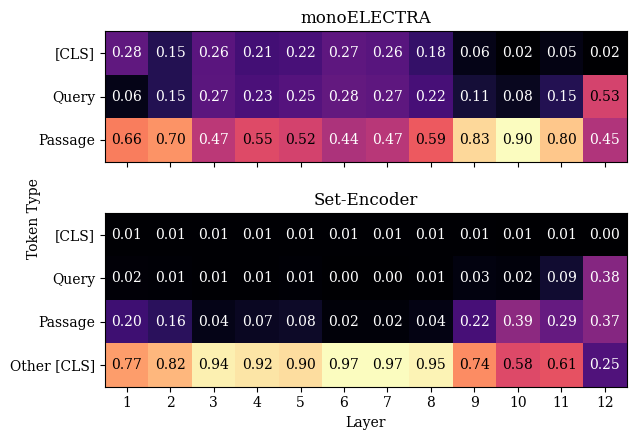

In [37]:
%matplotlib inline

xlabels = ["[CLS]", "Query", "Passage", "Other [CLS]"]
fig, axes = plt.subplots(2, 1, figsize=(6.4, 4.6), sharex=True)
xlim = None
for ax_idx, (title, plot_attention) in enumerate(plot_attentions.items()):
    ax = axes[ax_idx]
    # plot_attention = plot_attention[,::-1]
    num_layers = plot_attention.shape[1]
    ax.imshow(plot_attention, cmap="magma")
    # ax.set_aspect("equal")
    # ax.set_yticks(range(5), labels=["[CLS]", "[OD]", "Query", "Doc", "Other Doc"])
    # if xlim is None:
    #     ax.set_xlim(0, num_layers)
    #     xlim = ax.get_xlim()
    num_tokens = plot_attention.shape[0]
    ax.set_yticks(range(num_tokens), labels=xlabels[:num_tokens])
    # ax.set_xticks(range(num_layers), labels=range(num_layers, 0, -1))
    ax.set_xticks(range(num_layers), labels=range(1, num_layers+1))
    # ax.set_ylabel("Token Type")
    if ax_idx:
        ax.set_xlabel("Layer")
    # else:
    #     ax.set_xticks([])
    ax.set_title(title)
    for x in range(plot_attention.shape[0]):
        for y in range(plot_attention.shape[1]):
            if plot_attention[x, y] > 0:
                if plot_attention[x, y] < 0.5:
                    color = "white"
                else:
                    color = "black"
                ax.text(
                    y,
                    x,
                    f"{plot_attention[x, y]:.2f}",
                    ha="center",
                    va="center",
                    color=color,
                )
fig.text(0.04, 0.5, 'Token Type', va='center', rotation='vertical')
fig.tight_layout()
fig.savefig(f"attention-saliency.pdf", bbox_inches="tight", pad_inches=0, dpi=300)